<div class="jumbotron text-left"><b>
    
This tutorial describes how to use the SMT toolbox to solve unconstrained optimization problem using the EGO-p algorithm.
</b>
</div>
    
    
The EGO-p is a parallel extension of the EGO algorithm, that implement the qEI aproximation.

Ref :
- David et al, 2010, Kriging Is Well-Suited to Parallelize Optimization, https://doi.org/10.1007/978-3-642-10701-6_6
- Roux et al, 2020 (under rev.), An efficient parallel global optimization strategy based on Kriging properties suitable for material parameters identification

Emile Roux, Univ. Savoie Mont Blanc, Symme Lab. April 2020


 <p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

In [46]:
import numpy as np 
import matplotlib.pyplot as plt
from smt.applications.egop import EGO_para
from smt.sampling_methods import LHS

In [47]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## All option of the EGO alogrithm are avaliable :
* Choose your criterion to perform the optimization: EI, SBO or UCB
* Choose the size of the initial DOE
* Choose the number of EGO iterations

## Try with a 2D function : The Branin function 

In [38]:
#Load the function from SMT.problems
from smt.problems.branin import Branin
from smt.problems.ndim_rosenbrock import NdimRosenbrock

test_func = Branin()
#test_func = NdimRosenbrock(ndim=2)
xlimits=test_func.xlimits
xlimits

array([[-5., 10.],
       [ 0., 15.]])

<IPython.core.display.Javascript object>


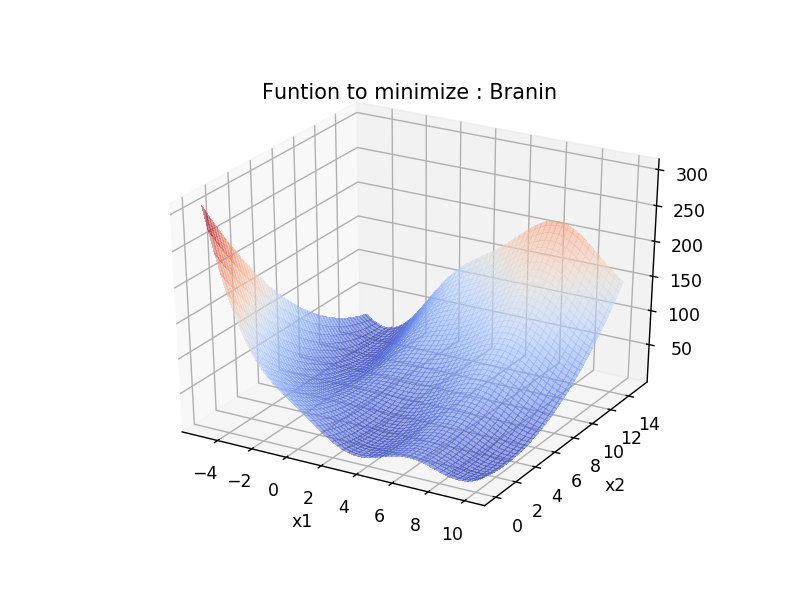

In [39]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

#To plot the Branin function
num_plot = 100 #to plot rosenbrock
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
y = np.linspace(xlimits[1][0],xlimits[1][1],num_plot)
res = []
for x0 in x:
    for x1 in y:
        res.append(test_func(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((num_plot,num_plot)).T
X,Y = np.meshgrid(x,y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title('Funtion to minimize : {}'.format(test_func.options['name']))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Prepare the function to be call in a parallel way
The gaol is to run the call of the function in parallel. To do that we will creat an extar function that embed the function to minimize. 

The `joblib` modul is used to paralelized the function.

The `fun_para` function must be definded folowing  :
- Input : 
    - n * dim numpy array (the x_data to evaluate) 
    - number of cores to use
- Output : n numpy array (return as a `atleast_2d()` numpy array)

In [40]:
from joblib import Parallel, delayed
import multiprocessing

def fun_para(x, num_cores=2):
    """
    Function that call the function to minimize en //
    """
    inputs = range(len(x))         
    results = Parallel(n_jobs=num_cores)(delayed(test_func)(np.atleast_2d(x[i])) for i in inputs)
    results = np.atleast_2d(np.asanyarray(results).flatten()).T
    return results

### Exemple of `fun_para`
1 - Let's creat a doe using the smt tool

In [41]:
from smt.sampling_methods import LHS
lhs = LHS(xlimits=xlimits, criterion="ese")
doe = lhs(5)
doe

array([[-3.9323622 ,  8.92854653],
       [-0.32629252,  0.97809876],
       [ 7.34467613, 11.42964447],
       [ 2.68850246, 12.15353554],
       [ 5.07070872,  5.32750538]])

2 - Let's evaluate all this points usnig the `fun_para` function

In [42]:
fun_para(doe)

array([[ 31.63063313],
       [ 49.9531233 ],
       [117.71021811],
       [ 91.59145815],
       [ 29.98276152]])

 ## Use the EGO-p from SMT to perform the minimization 

In [43]:
criterion='EI' #'EI' or 'SBO' or 'UCB'

#number of points in the initial DOE
ndoe = 9 #(at least ndim+1)

#number of iterations with EGO 
n_iter = 15

#number of sub-iterations with EGO-p 
n_par = 2

#Build the initial DOE
sampling = LHS(xlimits=xlimits)
xdoe = sampling(ndoe)


#EGO call
ego = EGO_para(n_iter=n_iter,
               criterion=criterion,
               xdoe=xdoe,
               xlimits=xlimits,
               verbose=True,
               n_par=n_par)

x_opt, y_opt, ind_best, x_data, y_data, x_doe, y_doe, krig = ego.optimize(fun=test_func)

print('Xopt ', x_opt,y_opt, ' obtained using EGO-p = ', criterion )
print('---------------------------')


Initial DOE given
JobRunner (2 cores) :
	 Start Running 9 function evaluations in parallel
	 End parallel Running
Internal optimization succeeded at EGO iter = 0.0
Internal optimization succeeded at EGO iter = 0.1
JobRunner (2 cores) :
	 Start Running 2 function evaluations in parallel
	 End parallel Running
Internal optimization succeeded at EGO iter = 1.0
Internal optimization succeeded at EGO iter = 1.1
JobRunner (2 cores) :
	 Start Running 2 function evaluations in parallel
	 End parallel Running
Internal optimization succeeded at EGO iter = 2.0
Internal optimization succeeded at EGO iter = 2.1
JobRunner (2 cores) :
	 Start Running 2 function evaluations in parallel
	 End parallel Running
Internal optimization succeeded at EGO iter = 3.0
Internal optimization succeeded at EGO iter = 3.1
JobRunner (2 cores) :
	 Start Running 2 function evaluations in parallel
	 End parallel Running
Internal optimization succeeded at EGO iter = 4.0
Internal optimization succeeded at EGO iter = 4.1
Jo

<IPython.core.display.Javascript object>


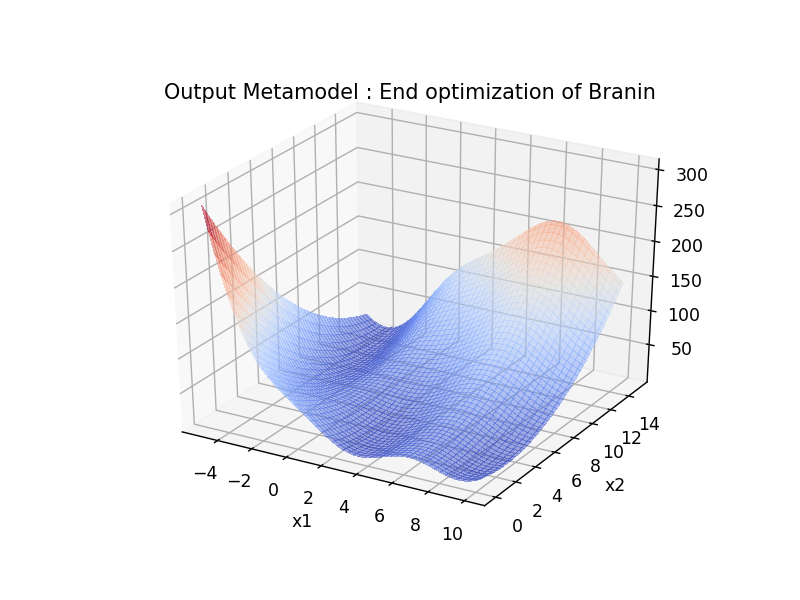

In [44]:
#To plot the MM 
num_plot = 100 #to plot rosenbrock
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
y = np.linspace(xlimits[1][0],xlimits[1][1],num_plot)
resMM = []
for x0 in x:
    for x1 in y:
        resMM.append(krig.predict_values(np.array([[x0,x1]])))
resMM = np.array(resMM)
resMM = resMM.reshape((num_plot,num_plot)).T
X,Y = np.meshgrid(x,y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, resMM, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title('Output Metamodel : End optimization of {}'.format(test_func.options['name']))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<IPython.core.display.Javascript object>


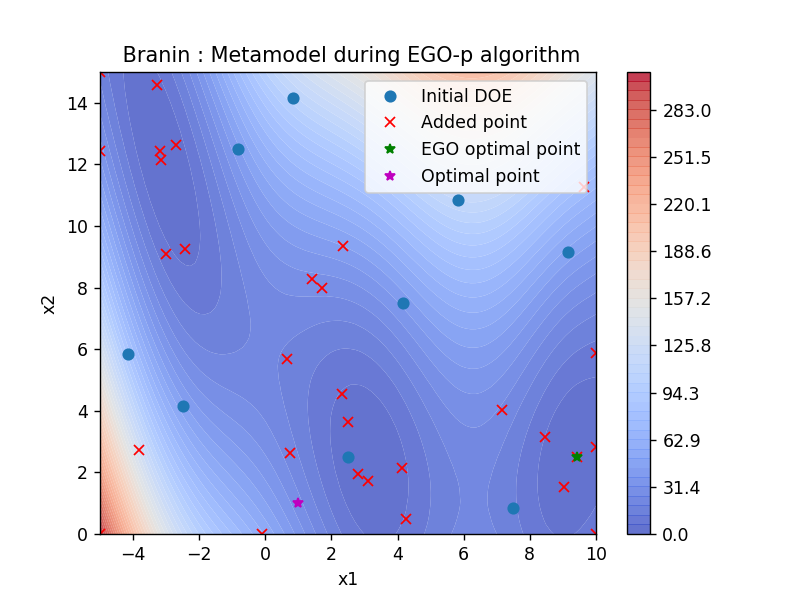

In [45]:
#2D plot 
#to add the points provided by EGO-p
fig = plt.figure()
cont = plt.contourf(X, Y, resMM, cmap=cm.coolwarm,
             antialiased=True,
             levels=np.linspace(0,np.max(resMM),50),
             alpha=0.8)
plt.plot(x_doe[:,0],x_doe[:,1],'o', label='Initial DOE')
plt.plot(x_data[ndoe:,0],x_data[ndoe:,1],'x', c='r', label='Added point')
plt.plot(x_opt[0],x_opt[1],'*',c='g', label= 'EGO optimal point')
plt.plot(1, 1,'*',c='m', label= 'Optimal point')
plt.colorbar(cont)
plt.title(' {} : Metamodel during EGO-p algorithm'.format(test_func.options['name']))
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()